In [1]:
import pandas as pd
import numpy as np

# Data Munging Script
This script concatenates the responses for identically worded questions into a single column. Where multiple responses are allowed, responses will be separated by a comma. See below for example outputs.

NOTE: multiple instances of 'biodiversity' being left out of questions in different survey tracks, despite these being intended to measure the same thing. Thus, we can't use the question text exactly to identify identical questions, we must use the codes provided in RAW_CODED.

?: "I believe most biodiversity programs" and "I believe most USAID biodiversity programs"... same question or different?

In [37]:
raw_inputs = pd.read_excel(r'C:\Users\Erik\OneDrive - Environmental Incentives\Downloads\mi2-data.xlsx', 'RAW_INPUT', header=[0,1], engine='openpyxl', date_parser=[3,4])
raw_coded = pd.read_excel(r'C:\Users\Erik\OneDrive - Environmental Incentives\Downloads\mi2-data.xlsx', 'RAW_CODED', header=None, engine='openpyxl', date_parser=[3,4])

# rename headers (can't read in duplicate headers, must rename)
# TODO: create a single list-like table instead of reading in RAW_CODED
coded_df = raw_inputs.copy()
coded_df.columns = raw_coded.iloc[0]
coded_df.columns

# concatenate identical questions and drop response row
columns = coded_df.columns
column_filters = [columns.get_loc(c) for c in columns]  # -> int if unique else boolean array 
series = []
already_seen = set()
for i in column_filters:
    if type(i)==int:
        series.append(coded_df.iloc[:,i])
    elif type(i)==np.ndarray:
        s = coded_df.iloc[:,i].copy()
        name = s.columns[0]
        if name not in already_seen:
            s = s.apply(lambda x: ', '.join(x.dropna().astype(str)), axis=1)
            s.name = name
            series.append(s)
            already_seen.add(name)
clean_df = pd.concat(series, axis=1)

# convert all empty cells to nan
clean_df = clean_df.replace(r'^\s*$', np.nan, regex=True)

# save to csv
clean_df.to_csv('clean_df.csv')


## DO NOT USE

In [6]:
# dff = pd.read_excel(r'C:\Users\Erik\OneDrive - Environmental Incentives/Downloads/mi2-data.xlsx', 'RAW_INPUT', header=[0,1], engine='openpyxl', date_parser=[3,4])

# # THIS CAN ALL BE DONE WITH ONLY THE LEVEL 1
# # (1) strip columns of returns
# # (2) update instances of 'previous response' to point to previous column
# columns = []
# for idx, column in enumerate(dff.columns):
#     level1 = str(column[0]).strip()
#     level2 = str(column[1]).strip()
#     if 'previous response' in level1.lower():
#         previous_question = dff.columns[idx-1][0]
#         new_level1 = level1 + '(' + previous_question + ')'
#         columns.append((new_level1, level2))
#     else:
#         columns.append((level1, level2))
# dff.columns = pd.MultiIndex.from_tuples(columns, names=["first", "second"])

# # concatenate identical questions and drop response row
# level_ones = dff.columns.get_level_values('first')
# column_filters = [level_ones.get_loc(c) for c in level_ones]  # -> int if unique else boolean array 
# series = []
# already_seen = set()
# for i in column_filters:
#     if type(i)==int:
#         s = dff.iloc[:,i].copy()
#         s.name = s.name[0]
#         series.append(s)
#     elif type(i)==np.ndarray:
#         s = dff.iloc[:,i].copy()
#         name = s.columns[0][0]
#         if name not in already_seen:
#             s = s.droplevel('second', axis=1)
#             s = s.apply(lambda x: ', '.join(x.dropna().astype(str)), axis=1)
#             s.name = name
#             series.append(s)
#             already_seen.add(name)
# clean_df = pd.concat(series, axis=1)

# # convert all empty cells to nan
# clean_df = clean_df.replace(r'^\s*$', np.nan, regex=True)

# # save to csv
# clean_df.to_csv('clean_df.csv')


## Data Munging Walk-through

In [3]:
dff = pd.read_excel(r'C:\Users\Erik\OneDrive - Environmental Incentives/Downloads/mi2-data.xlsx', 'RAW_INPUT', header=[0,1], engine='openpyxl', date_parser=[3,4])
for column in dff.columns:
    print(column)

('Respondent ID', 'Unnamed: 0_level_1')
('Collector ID', 'Unnamed: 1_level_1')
('Start Date', 'Unnamed: 2_level_1')
('End Date', 'Unnamed: 3_level_1')
('IP Address', 'Unnamed: 4_level_1')
('Email Address', 'Unnamed: 5_level_1')
('First Name', 'Unnamed: 6_level_1')
('Last Name', 'Unnamed: 7_level_1')
('Custom Data 1', 'Unnamed: 8_level_1')
('Are you willing to participate in the survey?\n \n ', 'Response')
('We will ask you to create a unique identifier so the survey analysis team can identify repeated responses across years. Please respond with the first letter of your birth city, the third letter of your birth month, and the last two digits of your phone number. Example: someone born in Seattle, in March, phone (202) 123-4567 would answer SR67', 'Open-Ended Response')
('Please indicate your gender (optional)\n ', 'Open-Ended Response')
('Did you support a USAID biodiversity program in the past year?', 'Yes')
('Did you support a USAID biodiversity program in the past year?', 'No')
('Di

In [204]:
dff[('Did you support a USAID biodiversity program in the past year?', 'Yes')].count()

71

<AxesSubplot:ylabel='(I believe the use of adaptive management improves biodiversity program outcomes.\n \n \n , Response)'>

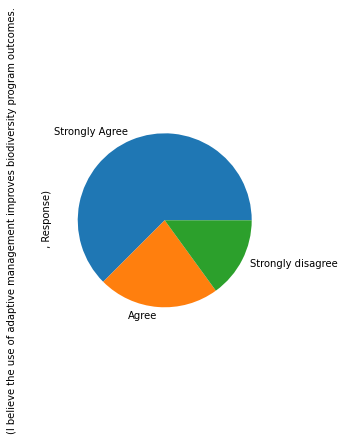

In [205]:
dff[('I believe the use of adaptive management improves biodiversity program outcomes.\n \n \n ', 'Response')].value_counts().plot(kind='pie')

In [206]:
dff[('We will ask you to create a unique identifier so the survey analysis team can identify repeated responses across years. Please respond with the first letter of your birth city, the third letter of your birth month, and the last two digits of your phone number. Example: someone born in Seattle, in March, phone (202) 123-4567 would answer SR67', 'Open-Ended Response')].nunique()==dff[('We will ask you to create a unique identifier so the survey analysis team can identify repeated responses across years. Please respond with the first letter of your birth city, the third letter of your birth month, and the last two digits of your phone number. Example: someone born in Seattle, in March, phone (202) 123-4567 would answer SR67', 'Open-Ended Response')].count()

False

In [207]:
# THIS CAN ALL BE DONE WITH ONLY THE LEVEL 1
# strip columns of returns
columns = []
for column in dff.columns:
    level1 = column[0].strip()
    level2 = column[1].strip()
    columns.append((level1, level2))
dff.columns = pd.MultiIndex.from_tuples(columns, names=["first", "second"])
dff.columns[17]

('What stage(s) in the Program Cycle were you supporting? (select all that apply)',
 'Strategy (CDCS)')

In [208]:
# update instances of 'previous response' to point to previous column
new_columns = []
for idx, column in enumerate(dff.columns):
    level1 = column[0]
    level2 = column[1]
    if 'previous response' in level1.lower():
        previous_question = dff.columns[idx-1][0]
        new_level1 = level1 + '(' + previous_question + ')'
        new_columns.append((new_level1, level2))
    else:
        new_columns.append((level1, level2))


Please provide some context to your previous response.(I am confident in my ability to apply adaptive management to my work.)
Please provide some context to your previous response.(I believe I can overcome barriers to implementing adaptive management.)
Please provide some context to your previous response.(I am confident in my ability to apply adaptive management to my work.)
Please provide some context to your previous response.(I believe I can overcome barriers to implementing adaptive management.)
Please provide some context to your previous response.(I am confident in my ability to support the use of adaptive management through my work.)
Please provide some context to your previous response.(I believe I can overcome barriers affecting my support to biodiversity teams implementing adaptive management.)
Please provide some context to your previous response.(I am confident in my ability to support the use of adaptive management through my work.)
Please provide some context to your pre

In [209]:
dff.columns = pd.MultiIndex.from_tuples(new_columns, names=["first", "second"])
dff.columns[50]

('Please provide some context to your previous response.(I am confident in my ability to support the use of adaptive management through my work.)',
 'Open-Ended Response.4')

In [210]:
# merge columns where level one (question header) is the same
level_ones = dff.columns.get_level_values('first')
column_index_first_seen = [level_ones.get_loc(c) for c in level_ones]
column_index_first_seen

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 array([False, False, False, False, False, False, False, False, False,
        False, False, False,  True,  True,  True,  True,  True, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False]),
 array([False, False, False, False, False, False, False, Fal

In [211]:
example_question = dff.iloc[:,column_index_first_seen[17]]
example_question

first  What stage(s) in the Program Cycle were you supporting? (select all that apply)  \
second                                                                 Strategy (CDCS)   
0                                                     NaN                                
1                                         Strategy (CDCS)                                
2                                                     NaN                                
3                                         Strategy (CDCS)                                
4                                         Strategy (CDCS)                                
..                                                    ...                                
89                                                    NaN                                
90                                                    NaN                                
91                                                    NaN                                
92                                                    NaN                                
93                                        Strategy (CDCS)                                

first                                                             \
second  Project design (PAD)  Activity design and/or procurement   
0                        NaN  Activity design and/or procurement   
1       Project design (PAD)  Activity design and/or procurement   
2                        NaN  Activity design and/or procurement   
3       Project design (PAD)  Activity design and/or procurement   
4       Project design (PAD)  Activity design and/or procurement   
..                       ...                                 ...   
89      Project design (PAD)  Activity design and/or procurement   
90                       NaN                                 NaN   
91                       NaN  Activity design and/or procurement   
92      Project design (PAD)  Activity design and/or procurement   
93      Project design (PAD)  Activity design and/or procurement   

first                                                           \
second  Activity start up  Activity implementation  Evaluation   
0                     NaN  Activity implementation         NaN   
1       Activity start up  Activity implementation  Evaluation   
2                     NaN                      NaN         NaN   
3       Activity start up  Activity implementation  Evaluation   
4                     NaN                      NaN  Evaluation   
..                    ...                      ...         ...   
89      Activity start up  Activity implementation  Evaluation   
90                    NaN                      NaN         NaN   
91      Activity start up  Activity implementation         NaN   
92                    NaN  Activity implementation         NaN   
93      Activity start up  Activity implementation  Evaluation   

first                          
second Other (please specify)  
0                         NaN  
1                         NaN  
2                         NaN  
3                         NaN  
4                         NaN  
..                        ...  
89                        NaN  
90                        NaN  
91                        NaN  
92                        NaN  
93                        NaN  

[94 rows x 7 columns]

In [212]:
example_question.droplevel('second', axis=1)

first,What stage(s) in the Program Cycle were you supporting? (select all that apply),What stage(s) in the Program Cycle were you supporting? (select all that apply),What stage(s) in the Program Cycle were you supporting? (select all that apply),What stage(s) in the Program Cycle were you supporting? (select all that apply),What stage(s) in the Program Cycle were you supporting? (select all that apply),What stage(s) in the Program Cycle were you supporting? (select all that apply),What stage(s) in the Program Cycle were you supporting? (select all that apply)
0,NaN,NaN,Activity design and/or procurement,NaN,Activity implementation,NaN,NaN
1,Strategy (CDCS),Project design (PAD),Activity design and/or procurement,Activity start up,Activity implementation,Evaluation,NaN
2,NaN,NaN,Activity design and/or procurement,NaN,NaN,NaN,NaN
3,Strategy (CDCS),Project design (PAD),Activity design and/or procurement,Activity start up,Activity implementation,Evaluation,NaN
4,Strategy (CDCS),Project design (PAD),Activity design and/or procurement,NaN,NaN,Evaluation,NaN
...,...,...,...,...,...,...,...
89,NaN,Project design (PAD),Activity design and/or procurement,Activity start up,Activity implementation,Evaluation,NaN
90,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91,NaN,NaN,Activity design and/or procurement,Activity start up,Activity implementation,NaN,NaN
92,NaN,Project design (PAD),Activity design and/or procurement,NaN,Activity implementation,NaN,NaN


In [213]:
example_question.columns[0][0]

'What stage(s) in the Program Cycle were you supporting? (select all that apply)'

In [214]:
example_question.apply(lambda x: ', '.join(x.dropna().astype(str)), axis=1)


0     Activity design and/or procurement, Activity i...
1     Strategy (CDCS), Project design (PAD), Activit...
2                    Activity design and/or procurement
3     Strategy (CDCS), Project design (PAD), Activit...
4     Strategy (CDCS), Project design (PAD), Activit...
                            ...                        
89    Project design (PAD), Activity design and/or p...
90                                                     
91    Activity design and/or procurement, Activity s...
92    Project design (PAD), Activity design and/or p...
93    Strategy (CDCS), Project design (PAD), Activit...
Length: 94, dtype: object

In [215]:
series = []
already_seen = set()
for i in column_index_first_seen:
    if type(i)==int:
        s = dff.iloc[:,i].copy()
        s.name = s.name[0]
        series.append(s)
    elif type(i)==np.ndarray:
        s = dff.iloc[:,i].copy()
        name = s.columns[0][0]
        if name not in already_seen:
            s = s.droplevel('second', axis=1)
            s = s.apply(lambda x: ', '.join(x.dropna().astype(str)), axis=1)
            s.name = name
            series.append(s)
            already_seen.add(name)

In [216]:
clean_df = pd.concat(series, axis=1)
for c in clean_df.columns:
    print(c + '\n')

Respondent ID

Collector ID

Start Date

End Date

IP Address

Email Address

First Name

Last Name

Custom Data 1

Are you willing to participate in the survey?

We will ask you to create a unique identifier so the survey analysis team can identify repeated responses across years. Please respond with the first letter of your birth city, the third letter of your birth month, and the last two digits of your phone number. Example: someone born in Seattle, in March, phone (202) 123-4567 would answer SR67

Please indicate your gender (optional)

Did you support a USAID biodiversity program in the past year?

What stage(s) in the Program Cycle were you supporting? (select all that apply)

What best describes your role in the USAID biodiversity program you supported most recently? (choose one)

Please indicate the USAID operating unit you were associated with when serving in this role.

I believe the use of adaptive management improves biodiversity program outcomes.

I believe adaptive manag

# Indicator Calculation
[Indicator1.1c](#Indicator-1.1c)

In [7]:
df = pd.read_excel(r'C:\Users\Erik\OneDrive - Environmental Incentives/Downloads/mi2-data.xlsx', 'RAW_CODED', header=None, engine='openpyxl', date_parser=[3,4])
df.iloc[0]

0           RESP_ID
1      Collector ID
2        Start Date
3          End Date
4        IP Address
           ...     
107           PR6-5
108           PR3-4
109           PR7-4
110           PR4-3
111           PR8-5
Name: 0, Length: 112, dtype: object

## OPTION 1: RENAME CLEAN_DF BY DICTIONARY OF CODES
This option takes advantage of the cleaning already done to the raw inputs and renames based on a dictionary. The dictionary is constructed for now by comparing the headers in the RAW_CODED tab to the level one headers in the RAW_INPUTS tab, and can be updated to run based on the CODEBOOK tab once complete. This approach requires that all meaningful codes be mapped to level one survey questions. The advantage to this approach is that it does not require the RAW_CODED sheet once the CODEBOOK is complete.

In [17]:
# create dictionary of questions to codes based on headers in INPUTS vs CODED
# NOTE THIS MIGHT RESULT IN DUPLICATE COLUMN NAMES
d = {}
for code, question in zip(df.iloc[0], dff.columns.get_level_values(0)):
    d[question] = code
d

{'Respondent ID': 'RESP_ID',
 'Collector ID': 'Collector ID',
 'Start Date': 'Start Date',
 'End Date': 'End Date',
 'IP Address': 'IP Address',
 'Email Address': 'Email Address',
 'First Name': 'First Name',
 'Last Name': 'Last Name',
 'Custom Data 1': 'Custom Data 1',
 'Are you willing to participate in the survey?': 'BD1-4',
 'We will ask you to create a unique identifier so the survey analysis team can identify repeated responses across years. Please respond with the first letter of your birth city, the third letter of your birth month, and the last two digits of your phone number. Example: someone born in Seattle, in March, phone (202) 123-4567 would answer SR67': 'ID1-1',
 'Please indicate your gender (optional)': 'GN1-1',
 'Did you support a USAID biodiversity program in the past year?': 'BD4-2',
 'What stage(s) in the Program Cycle were you supporting? (select all that apply)': 'BD3-1',
 'What best describes your role in the USAID biodiversity program you supported most recentl

In [18]:
coded_df = clean_df.rename(columns=d)
coded_df.columns

Index(['RESP_ID', 'Collector ID', 'Start Date', 'End Date', 'IP Address',
       'Email Address', 'First Name', 'Last Name', 'Custom Data 1', 'BD1-4',
       'ID1-1', 'GN1-1', 'BD4-2', 'BD3-1', 'BD4-2', 'MISS_NAME', 'AM6-3',
       'AM9-1', 'AM7-1', 'OPEN1', 'AM8-2', 'OPEN2', 'AM13-1', 'OEPN1',
       'AM14-4', 'OPEN2', 'AM1-2', 'AM4-2', 'AM2-2', 'EV3-4', 'EV2-4', 'PR1-5',
       'PR5-5', 'PR2-4', 'PR6-5', 'PR3-4', 'PR7-4', 'PR4-3', 'PR8-5', 'MI1-4',
       'MI2-4', 'MI3-4OTH', 'MI4-5', 'MI6.1-3', 'MI6.2-3', 'MI6.3-3',
       'MI6.4-3', 'MI6.5-3', 'MI6.6-3', 'MI6.7-1', 'MI7-4', 'MI9-4', 'AM5-2',
       'AM12-2', 'AM11-2', 'EV4-4', 'PR5-5', 'PR3-4'],
      dtype='object')

## OPTION 2: RENAME HEADERS DIRECTLY
This approach simply replaces the column headers in RAW_INPUTS with the column headers in RAW_CODED. This requires we maintain an ordered list of coded headers, and is sensitive to changes in how surveymonkey returns data. Any changes to the survey (even simply to the order) could cause this to fail.

HOwever, because questions are not identical, this is the required approach.

In [ ]:
# coded_df = dff.copy()
# coded_df.columns = df.iloc[0]
# coded_df.columns

## Indicator 1.1a
Shared understanding of the value of AM for biodiversity programming					
This sub-indicator is calculated as the percentage of respondents that agrees or strongly agrees that AM improves biodiversity outcomes converted to a 5-point scale.					

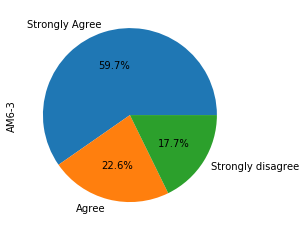

In [41]:
clean_df['AM6-3'].value_counts().plot(kind='pie', autopct='%1.1f%%')

In [43]:
n = clean_df['AM6-3'].notnull().sum()
i1_1a = clean_df['AM6-3'].map(agreement_dict).sum()/clean_df['AM6-3'].notnull().sum()
print(f'n: {n}, {i1_1a: .2%}')

n: 62,  82.26%


In [73]:
# store response-level results in column i1_1a
clean_df['i1_1a_values'] = clean_df['AM6-3']
clean_df['i1_1a'] = clean_df['i1_1a_values'].isin(['Strongly Agree', 'Agree'])
filt = clean_df['i1_1a_values'].isna()
clean_df['i1_1a'] = clean_df['i1_1a'].mask(filt, np.nan)
clean_df[['i1_1a_values', 'i1_1a']]

,i1_1a_values,i1_1a
0,Agree,1.0
1,Strongly Agree,1.0
2,Agree,1.0
3,Strongly Agree,1.0
4,Agree,1.0
...,...,...
89,Strongly disagree,0.0
90,NaN,NaN
91,Strongly Agree,1.0
92,Agree,1.0


## Indicator 1.1b
Note: if the respondent does not respond to any of the 4 prompts, they are dropped.

In [52]:
clean_df[['RESP_ID', 'PR5-5', 'PR6-5', 'PR7-4', 'PR8-5']].head(10)

,RESP_ID,PR5-5,PR6-5,PR7-4,PR8-5
0,12477972045,Important,Very important,Very important,Very important
1,12477891999,Very important,Very important,Very important,Important
2,12477891089,Important,I don’t know,Very important,Important
3,12477471535,Very important,Important,Very important,Very important
4,12477102564,Very important,Very important,Very important,Very important
5,12475822769,Important,Important,Important,Important
6,12474931760,Slightly important,Moderately important,NaN,NaN
7,12474693139,Very important,Very important,Very important,Very important
8,12474653021,Very important,Very important,Very important,Very important
9,12474304220,NaN,NaN,NaN,NaN


In [49]:
clean_df[['PR5-5', 'PR6-5', 'PR7-4', 'PR8-5']].apply(pd.Series.value_counts, axis=1)

,I don’t know,Important,Moderately important,Not important,Slightly important,Very important
0,NaN,1.0,NaN,NaN,NaN,3.0
1,NaN,1.0,NaN,NaN,NaN,3.0
2,1.0,2.0,NaN,NaN,NaN,1.0
3,NaN,1.0,NaN,NaN,NaN,3.0
4,NaN,NaN,NaN,NaN,NaN,4.0
...,...,...,...,...,...,...
89,NaN,NaN,NaN,NaN,NaN,4.0
90,NaN,NaN,NaN,NaN,NaN,NaN
91,NaN,1.0,1.0,NaN,NaN,2.0
92,NaN,4.0,NaN,NaN,NaN,NaN


In [319]:
response_count = clean_df[['PR5-5', 'PR6-5', 'PR7-4', 'PR8-5']].apply(pd.Series.value_counts, axis=1)
response_count[['Important', 'Very important']].sum(axis=1)

0     4.0
1     4.0
2     3.0
3     4.0
4     4.0
     ... 
89    4.0
90    0.0
91    3.0
92    4.0
93    4.0
Length: 94, dtype: float64

In [320]:
n = (response_count[['Important', 'Very important']].sum(axis=1) > 0).sum()
agreement = (response_count[['Important', 'Very important']].sum(axis=1) == 4).sum()

In [322]:
i1_1b = agreement / n

In [323]:
print(f'n: {n}, {i1_1a: .2%}')

n: 56,  82.26%


In [76]:
# store response-level results in column 1_1b
response_count = clean_df[['PR5-5', 'PR6-5', 'PR7-4', 'PR8-5']].apply(pd.Series.value_counts, axis=1)
clean_df['i1_1b_values'] = response_count[['Important', 'Very important']].sum(axis=1)
clean_df['i1_1b'] = clean_df['i1_1b_values'] == 4

# overwrite with na if any responses are missing
filt = clean_df[['PR5-5', 'PR6-5', 'PR7-4', 'PR8-5']].isna().any(axis=1)
clean_df['i1_1b'] = clean_df['i1_1b'].mask(filt, np.nan)
clean_df[['i1_1b_values', 'i1_1b']].head(10)

,i1_1b_values,i1_1b
0,4.0,1.0
1,4.0,1.0
2,3.0,0.0
3,4.0,1.0
4,4.0,1.0
5,4.0,1.0
6,0.0,NaN
7,4.0,1.0
8,4.0,1.0
9,0.0,NaN


In [151]:
n = clean_df['i1_1b'].count()
i = clean_df['i1_1b'].mean()
print(f'n: {n}, {i: .2%}')

n: 55,  83.64%


## Indicator 1.1c
Commitment to resourcing AM in biodiveristy programming					
This sub-indicator is calculated as the percentage of respondents that agrees or strongly agrees that environment teams have access to the resources needed to adaptively manage their programs converted to a 5-point scale.					


In [324]:
coded_df[['AM4-2', 'AM12-2']]

,AM4-2,AM12-2
0,Agree,NaN
1,Agree,NaN
2,Agree,NaN
3,Agree,NaN
4,Agree,NaN
...,...,...
89,Agree,NaN
90,NaN,NaN
91,NaN,Disagree
92,Agree,NaN


In [327]:
coded_df[['AM4-2', 'AM12-2']].apply(lambda x: ', '.join(x.dropna().astype(str)), axis=1)

0        Agree
1        Agree
2        Agree
3        Agree
4        Agree
        ...   
89       Agree
90            
91    Disagree
92       Agree
93       Agree
Length: 94, dtype: object

<AxesSubplot:ylabel='None'>

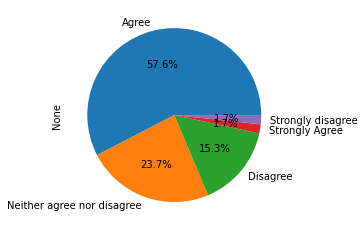

In [331]:
agreement11c = coded_df[['AM4-2', 'AM12-2']].apply(lambda x: ', '.join(x.dropna().astype(str)), axis=1)
agreement11c = agreement11c.replace(r'^\s*$', np.nan, regex=True)
agreement11c.value_counts().plot(kind='pie', autopct='%1.1f%%')

In [338]:
n = agreement11c.notnull().sum()
agreement = agreement11c.isin(['Strongly Agree', 'Agree']).sum()
i1_1c = agreement/n

In [339]:
print(f'n: {n}, {i1_1c: .2%}')

n: 59,  59.32%


In [79]:
# store response-level results in column i1_1c
clean_df['i1_1c_values'] = coded_df[['AM4-2', 'AM12-2']]\
    .apply(lambda x: ', '.join(x.dropna().astype(str)), axis=1)\
    .replace(r'^\s*$', np.nan, regex=True)
clean_df['i1_1c'] = clean_df['i1_1c_values'].isin(['Strongly Agree', 'Agree'])
# overwrite null values
filt = clean_df['i1_1c_values'].isna()
clean_df['i1_1c'] = clean_df['i1_1c'].mask(filt, np.nan)
clean_df[['i1_1c_values', 'i1_1c']]

,i1_1c_values,i1_1c
0,Agree,1.0
1,Agree,1.0
2,Agree,1.0
3,Agree,1.0
4,Agree,1.0
...,...,...
89,Agree,1.0
90,NaN,NaN
91,Disagree,0.0
92,Agree,1.0


## Indicator 1.1
Sector-wide shared understanding index					
This is a composite indicator calculated as the sum of three sub-indicators associated with a shared understanding of AM (range 3-15).					


In [83]:
means_1_1 = clean_df[['i1_1a', 'i1_1b', 'i1_1c']].mean()
means_1_1

i1_1a    0.822581
i1_1b    0.836364
i1_1c    0.593220
dtype: float64

In [97]:
bins = np.array([0, 0.2, 0.4, 0.6, 0.8, 1])
labels = [1, 2, 3, 4, 5]
scores_1_1 = pd.cut(means_1_1, bins=bins, labels=labels, right=False)  # right exclusive
scores_1_1

i1_1a    5
i1_1b    5
i1_1c    3
dtype: category
Categories (5, int64): [1 < 2 < 3 < 4 < 5]

In [99]:
i1_1 = scores_1_1.astype(int).sum()
print(f'Indicator 1.1 = {i1_1}')

Indicator 1.1 = 13


## Indicator 4.1

In [102]:
clean_df[['EV1-5', 'EV3-4', 'EV2-4', 'EV4-4']]

,EV1-5,EV3-4,EV2-4,EV4-4
0,Agree,NaN,Agree,NaN
1,Neither agree nor disagree,NaN,Neither agree nor disagree,NaN
2,Agree,NaN,Neither agree nor disagree,NaN
3,Strongly Agree,NaN,Agree,NaN
4,Agree,NaN,Agree,NaN
...,...,...,...,...
89,Agree,NaN,Neither agree nor disagree,NaN
90,NaN,NaN,NaN,NaN
91,NaN,Agree,NaN,Neither agree nor disagree
92,Agree,NaN,Neither agree nor disagree,NaN


In [105]:
agree_list = ['Agree', 'Strongly Agree']
filt = (clean_df['EV1-5'].isin(agree_list) | clean_df['EV3-4'].isin(agree_list))\
    & (clean_df['EV2-4'].isin(agree_list) | clean_df['EV4-4'].isin(agree_list))
clean_df.loc[filt, ['EV1-5', 'EV3-4', 'EV2-4', 'EV4-4']]

,EV1-5,EV3-4,EV2-4,EV4-4
0,Agree,NaN,Agree,NaN
3,Strongly Agree,NaN,Agree,NaN
4,Agree,NaN,Agree,NaN
11,Agree,NaN,Agree,NaN
12,Agree,NaN,Agree,NaN
18,Strongly Agree,NaN,Agree,NaN
24,Agree,NaN,Agree,NaN
34,Strongly Agree,NaN,Agree,NaN
35,NaN,Agree,NaN,Agree
36,Agree,NaN,Agree,NaN


In [107]:
clean_df['i4_1'] = filt
clean_df['i4_1']

0      True
1     False
2     False
3      True
4      True
      ...  
89    False
90    False
91    False
92    False
93     True
Name: i4_1, Length: 94, dtype: bool

In [110]:
filt = (clean_df[['EV1-5', 'EV3-4']].isna().all(axis=1)) \
    & (clean_df[['EV2-4', 'EV4-4']].isna().all(axis=1))
clean_df['i4_1'] = clean_df['i4_1'].mask(filt, np.nan)
clean_df['i4_1']

0     1.0
1     0.0
2     0.0
3     1.0
4     1.0
     ... 
89    0.0
90    NaN
91    0.0
92    0.0
93    1.0
Name: i4_1, Length: 94, dtype: float64

In [111]:
# store response-level results in column i4_1
agree_list = ['Agree', 'Strongly Agree']
filt = (clean_df['EV1-5'].isin(agree_list) | clean_df['EV3-4'].isin(agree_list))\
    & (clean_df['EV2-4'].isin(agree_list) | clean_df['EV4-4'].isin(agree_list))

# overwrite with na if any responses are missing
filt = (clean_df[['EV1-5', 'EV3-4']].isna().all(axis=1)) \
    & (clean_df[['EV2-4', 'EV4-4']].isna().all(axis=1))
clean_df['i4_1'] = clean_df['i4_1'].mask(filt, np.nan)
clean_df['i4_1'].head(10)

0    1.0
1    0.0
2    0.0
3    1.0
4    1.0
5    0.0
6    0.0
7    0.0
8    0.0
9    NaN
Name: i4_1, dtype: float64

In [117]:
n = clean_df['i4_1'].count()
i = clean_df['i4_1'].mean()
print(f'n: {n}, {i: .2%}')

n: 58,  39.66%


## Indicator 5.1
Percentage of respondents reporting broad uptake of AM practices in biodiversity programming					
This indicator is calculated as the percentage of respondents reporting a high level of use across all four practices identified in the survey. The sample only includes respondents who assessed all four practices.					


In [118]:
# store response-level results in column 1_1b
response_count = clean_df[['PR1-5', 'PR2-4', 'PR3-4', 'PR4-3']].apply(pd.Series.value_counts, axis=1)
clean_df['i5_1_values'] = response_count[['Agree', 'Strongly Agree']].sum(axis=1)
clean_df['i5_1'] = clean_df['i5_1_values'] == 4

# overwrite with na if any responses are missing
filt = clean_df[['PR1-5', 'PR2-4', 'PR3-4', 'PR4-3']].isna().any(axis=1)
clean_df['i5_1'] = clean_df['i5_1'].mask(filt, np.nan)
clean_df[['i5_1_values', 'i5_1']].head(10)

,i5_1_values,i5_1
0,4.0,1.0
1,4.0,1.0
2,3.0,0.0
3,4.0,1.0
4,4.0,1.0
5,4.0,1.0
6,0.0,NaN
7,4.0,1.0
8,4.0,1.0
9,0.0,NaN


In [122]:
n = clean_df['i5_1'].count()
agreement = clean_df['i5_1'].mean()
print(f'n: {n}, {agreement: .2%}')

n: 55,  56.36%


## Indicator 6.1
Percentage of respondents reporting that application of MI/MI2 practices had a positive effect on Program Cycle outputs					
This indicator is calculated as the percentage of respondents reporting that MI/MI2 practices had a moderate or strong poistive effect on the Program Cycle output for which they received techncial assistance. The sample excludes respondents who received TA but reported that they did not know the effect of MI/MI2 practices on the Program Cycle output.					


In [124]:
clean_df[['MI6.1-3', 'MI6.2-3', 'MI6.3-3', 'MI6.4-3', 'MI6.5-3', 'MI6.7-1']]

,MI6.1-3,MI6.2-3,MI6.3-3,MI6.4-3,MI6.5-3,MI6.7-1
0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,MI/MI2 support had a moderate positive effect ...
4,MI/MI2 support had little effect on the qualit...,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
89,NaN,NaN,MI/MI2 support had a large positive effect on ...,NaN,NaN,NaN
90,NaN,NaN,NaN,NaN,NaN,NaN
91,NaN,NaN,MI/MI2 support had a moderate positive effect ...,NaN,NaN,NaN
92,NaN,MI/MI2 support had a large positive effect on ...,NaN,NaN,NaN,NaN


In [142]:
clean_df['i6_1_values'] = clean_df[['MI6.1-3', 'MI6.2-3', 'MI6.3-3', 'MI6.4-3', 'MI6.5-3', 'MI6.6-3', 'MI6.7-1']].apply(lambda x: ''.join(x.dropna().astype(str)), axis=1)\
.replace(r'^\s*$', np.nan, regex=True)
clean_df['i6_1_values'].unique()
clean_df[clean_df['i6_1_values']=='I don’t know']

,RESP_ID,Collector ID,Start Date,End Date,IP Address,Email Address,First Name,Last Name,Custom Data 1,BD1-4,...,i1_1c_values,i4_1_values,i4_1,i5_1_values,i5_1,MI6.x,i1_6_values,i1_6,i6_1_values,i6_1
73,12076184709,263393441,2020-10-14 13:41:15,2020-10-14 13:48:28,191.177.158.154,NaN,NaN,NaN,NaN,Yes,...,Disagree,0.0,0.0,3.0,0.0,I don’t know,I don’t know,0.0,I don’t know,0.0
76,12075745917,263393441,2020-10-14 11:29:09,2020-10-14 11:40:02,190.166.150.20,NaN,NaN,NaN,NaN,Yes,...,Disagree,1.0,0.0,3.0,0.0,I don’t know,I don’t know,0.0,I don’t know,0.0
82,12074841297,263393441,2020-10-14 06:46:37,2020-10-14 06:55:46,41.66.230.40,NaN,NaN,NaN,NaN,Yes,...,Agree,2.0,1.0,4.0,1.0,I don’t know,I don’t know,0.0,I don’t know,0.0


In [132]:
clean_df['i6_1'] = clean_df['i6_1_values'].str.contains('positive').astype(float)
clean_df['i6_1']

0     NaN
1     NaN
2     NaN
3     1.0
4     0.0
     ... 
89    1.0
90    NaN
91    1.0
92    1.0
93    NaN
Name: i6_1, Length: 94, dtype: float64

In [143]:
mask = clean_df['i6_1_values']=='I don’t know'
clean_df['i6_1'] = clean_df['i6_1'].mask(mask, np.nan)

In [148]:
n = clean_df['i6_1'].count()
agreement = clean_df['i6_1'].mean()
print(f'n: {n}, {agreement: .2%}')

n: 40,  95.00%


In [147]:
# save record-level scores to i6_1
clean_df['i6_1_values'] = clean_df[['MI6.1-3', 'MI6.2-3', 'MI6.3-3', 'MI6.4-3', 'MI6.5-3', 'MI6.6-3', 'MI6.7-1']].apply(lambda x: ''.join(x.dropna().astype(str)), axis=1)\
.replace(r'^\s*$', np.nan, regex=True)
clean_df['i6_1'] = clean_df['i6_1_values'].str.contains('positive').astype(float)
# mask instances of 'I don't know' note unicode character for apostrophe
mask = clean_df['i6_1_values']=='I don’t know'
clean_df['i6_1'] = clean_df['i6_1'].mask(mask, np.nan)

In [149]:
clean_df.to_csv('clean_df.csv')